In [7]:
import tensorflow as tf
from tensorflow.keras import models, layers, applications
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [8]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10 
LEARNING_RATE = 0.001 

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"D:\MajorP\Images",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    color_mode='rgb'  # Explicitly preserve color information
)

Found 315 files belonging to 2 classes.


In [14]:
class_names = dataset.class_names
print(f"Classes: {class_names}")

Classes: ['Corroded', 'Non Corroded']


In [15]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0]


Image batch shape: (32, 256, 256, 3)
Labels: [1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0]


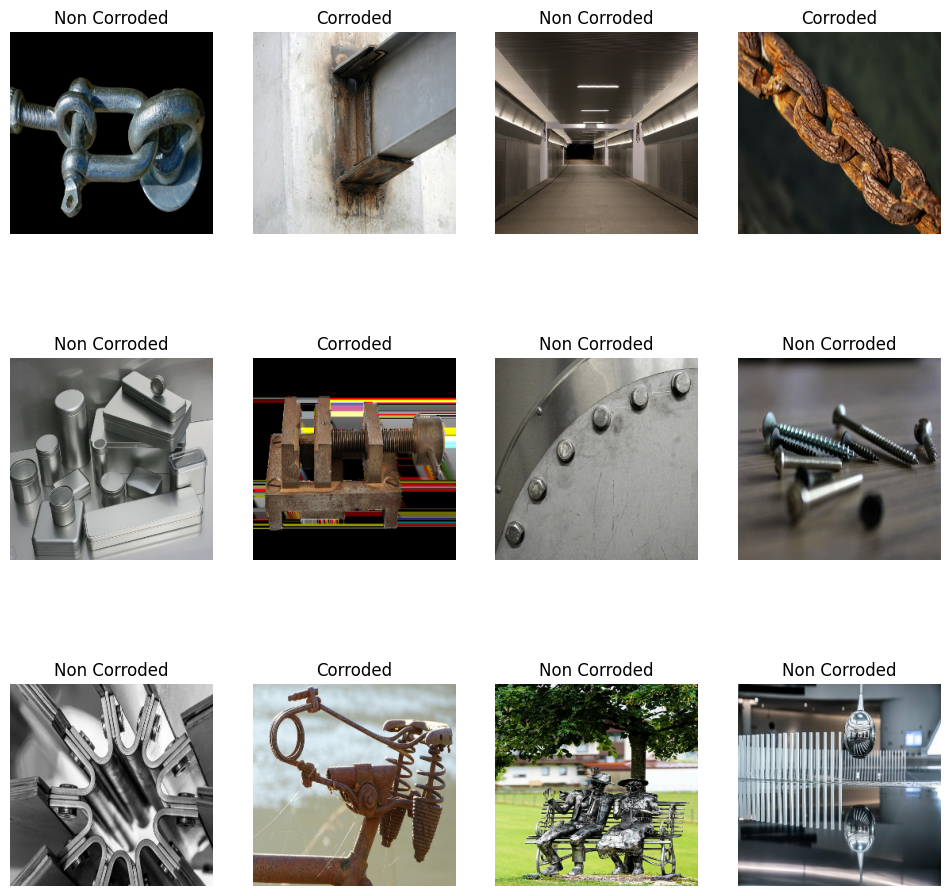

In [16]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Labels: {labels_batch.numpy()}")
    for i in range(min(12, len(image_batch))):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

10

In [12]:
train_size = 0.8
len(dataset)*train_size

8.0

In [13]:
train_ds = dataset.take(8)
len(train_ds)

8

In [14]:
test_ds = dataset.skip(8)
len(test_ds)

2

In [15]:
val_size=0.1
len(dataset)*val_size

1.0

In [16]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [17]:
test_ds = test_ds.skip(1)
len(test_ds)

1

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)  # Consistent seed for reproducibility
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 7, Validation size: 1, Test size: 2


In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(5000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
def preprocess_input(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    # Reshape the label to match the output shape of the model
    # This is the key fix for your shape incompatibility error
    label = tf.reshape(label, [-1])
    return image, label

# Apply preprocessing
train_ds = train_ds.map(preprocess_input).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(preprocess_input).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(preprocess_input).prefetch(buffer_size=AUTOTUNE)

# Data augmentation model
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

In [42]:
def build_color_aware_model(num_classes):
    # Use EfficientNet as base model
    base_model = applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Build model with color attention
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    
    # Apply data augmentation only during training
    x = inputs
    
    # Extract HSV color features as a separate pathway
    hsv_conversion = tf.keras.layers.Lambda(lambda x: tf.image.rgb_to_hsv(x))(inputs)
    
    # Extract HSV channels
    h_channel = tf.keras.layers.Lambda(lambda x: x[:,:,:,0:1])(hsv_conversion)
    s_channel = tf.keras.layers.Lambda(lambda x: x[:,:,:,1:2])(hsv_conversion)
    v_channel = tf.keras.layers.Lambda(lambda x: x[:,:,:,2:3])(hsv_conversion)
    
    # Process RGB features through EfficientNet
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Process color channels
    h_features = layers.Conv2D(16, 3, padding='same', activation='relu')(h_channel)
    h_features = layers.GlobalAveragePooling2D()(h_features)
    
    s_features = layers.Conv2D(16, 3, padding='same', activation='relu')(s_channel)
    s_features = layers.GlobalAveragePooling2D()(s_features)
    
    v_features = layers.Conv2D(16, 3, padding='same', activation='relu')(v_channel)
    v_features = layers.GlobalAveragePooling2D()(v_features)
    
    # Concatenate all features
    concat = layers.Concatenate()([x, h_features, s_features, v_features])
    
    # Dense layers
    x = layers.Dense(256, activation='relu')(concat)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer - ensure this matches your data format (sparse categorical)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    # Compile with appropriate metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [43]:
n_classes = len(class_names)
model = build_color_aware_model(n_classes)
model.summary()

# Learning rate scheduling for better convergence
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6
)

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_12 (Lambda)             (None, 256, 256, 3)  0           ['input_9[0][0]']                
                                                                                                  
 lambda_13 (Lambda)             (None, 256, 256, 1)  0           ['lambda_12[0][0]']              
                                                                                                  
 lambda_14 (Lambda)             (None, 256, 256, 1)  0           ['lambda_12[0][0]']        

In [33]:
print(f"Class names: {class_names}")
n_classes = len(class_names)
print(f"Number of classes: {n_classes}")

# Now let's examine the dataset format to find any issues
for images, labels in train_ds.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels dtype: {labels.dtype}")
    print(f"First few labels: {labels.numpy()[:10]}")  # Show some labels

# Let's check if the model is expecting the right shape
# Recreate the model with the correct number of classes
model = build_color_aware_model(n_classes)

# Print model input and output shapes
print(f"Model input shape: {model.input.shape}")
print(f"Model output shape: {model.output.shape}")

Class names: ['Corroded', 'Non Corroded']
Number of classes: 2
Image batch shape: (32, 256, 256, 3)
Labels shape: (32,)
Labels dtype: <dtype: 'int32'>
First few labels: [1 0 0 1 1 1 1 1 0 1]
Model input shape: (None, 256, 256, 3)
Model output shape: (None, 2)


In [44]:
class AugmentationCallback(tf.keras.callbacks.Callback):
    def on_train_batch_begin(self, batch, logs=None):
        # This callback will be called but we'll let the model handle the augmentation
        pass

In [45]:
# Create the callback
augmentation_callback = AugmentationCallback()

In [35]:
n_classes = len(class_names)
model = build_color_aware_model(n_classes)
model.summary()

# Create separate data augmentation model for training time augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_8 (Lambda)              (None, 256, 256, 3)  0           ['input_7[0][0]']                
                                                                                                  
 lambda_9 (Lambda)              (None, 256, 256, 1)  0           ['lambda_8[0][0]']               
                                                                                                  
 lambda_10 (Lambda)             (None, 256, 256, 1)  0           ['lambda_8[0][0]']         

In [37]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_8 (Lambda)              (None, 256, 256, 3)  0           ['input_7[0][0]']                
                                                                                                  
 lambda_9 (Lambda)              (None, 256, 256, 1)  0           ['lambda_8[0][0]']               
                                                                                                  
 lambda_10 (Lambda)             (None, 256, 256, 1)  0           ['lambda_8[0][0]']         

In [46]:
# @tf.function
# def train_step(model, optimizer, loss_fn, images, labels):
#     # Apply augmentation
#     images = data_augmentation(images, training=True)
    
#     with tf.GradientTape() as tape:
#         predictions = model(images, training=True)
#         loss = loss_fn(labels, predictions)
    
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     return loss, predictions
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6
# )

# # Early stopping to prevent overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=15, restore_best_weights=True
# )

In [48]:
history = model.fit(
    train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)),  # Apply augmentation only to training data
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/100
7/7 [==============================] - 26s 3s/step - loss: 0.7081 - accuracy: 0.5068 - val_loss: 0.6553 - val_accuracy: 0.6875 - lr: 8.0000e-06
Epoch 2/100
7/7 [==============================] - 25s 3s/step - loss: 0.7012 - accuracy: 0.5160 - val_loss: 0.6562 - val_accuracy: 0.6875 - lr: 8.0000e-06
Epoch 3/100
7/7 [==============================] - 25s 3s/step - loss: 0.7241 - accuracy: 0.4612 - val_loss: 0.6572 - val_accuracy: 0.6875 - lr: 8.0000e-06
Epoch 4/100
7/7 [==============================] - 22s 3s/step - loss: 0.7002 - accuracy: 0.5114 - val_loss: 0.6584 - val_accuracy: 0.6875 - lr: 8.0000e-06
Epoch 5/100
7/7 [==============================] - 22s 3s/step - loss: 0.6984 - accuracy: 0.5616 - val_loss: 0.6594 - val_accuracy: 0.6875 - lr: 8.0000e-06
Epoch 6/100
7/7 [==============================] - 24s 3s/step - loss: 0.6938 - accuracy: 0.5114 - val_loss: 0.6606 - val_accuracy: 0.6875 - lr: 8.0000e-06
Epoch 7/100
7/7 [==============================] - 21s 3s/step -

In [31]:
scores = model.evaluate(test_ds)

1/1 [==============================] - 3s 3s/step - loss: 0.0913 - accuracy: 0.9688


In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 8}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
type(history.history['loss'])

list

In [36]:
len(history.history['loss'])

50

In [37]:
history.history['loss'][:5]

[0.787445068359375,
 0.8743811845779419,
 0.7096700668334961,
 0.7042924761772156,
 0.6261889338493347]

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

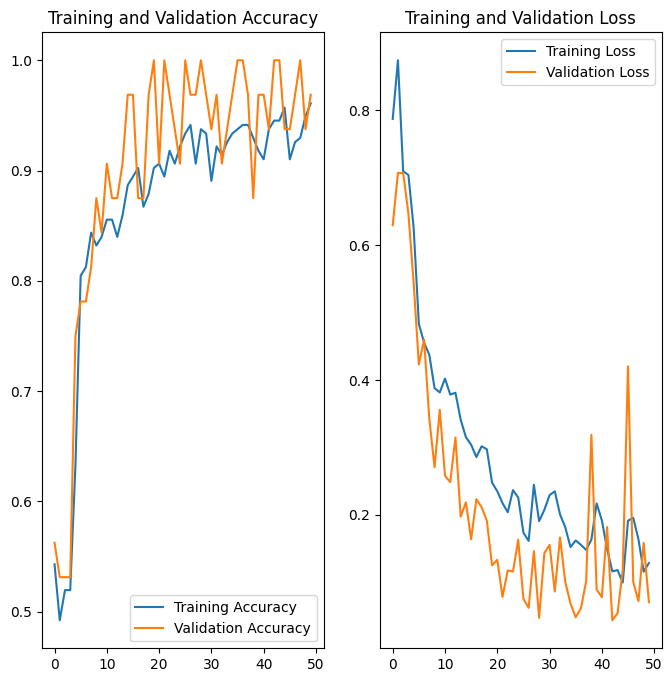

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Non Corroded
1/1 [==============================] - 1s 560ms/step
predicted label: Non Corroded


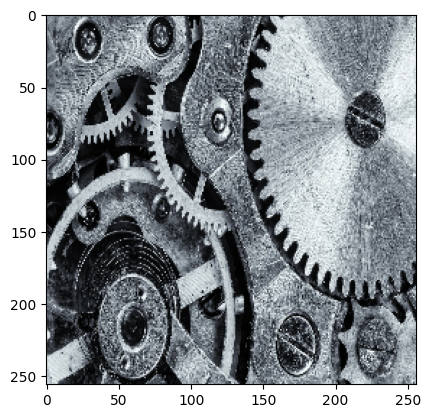

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


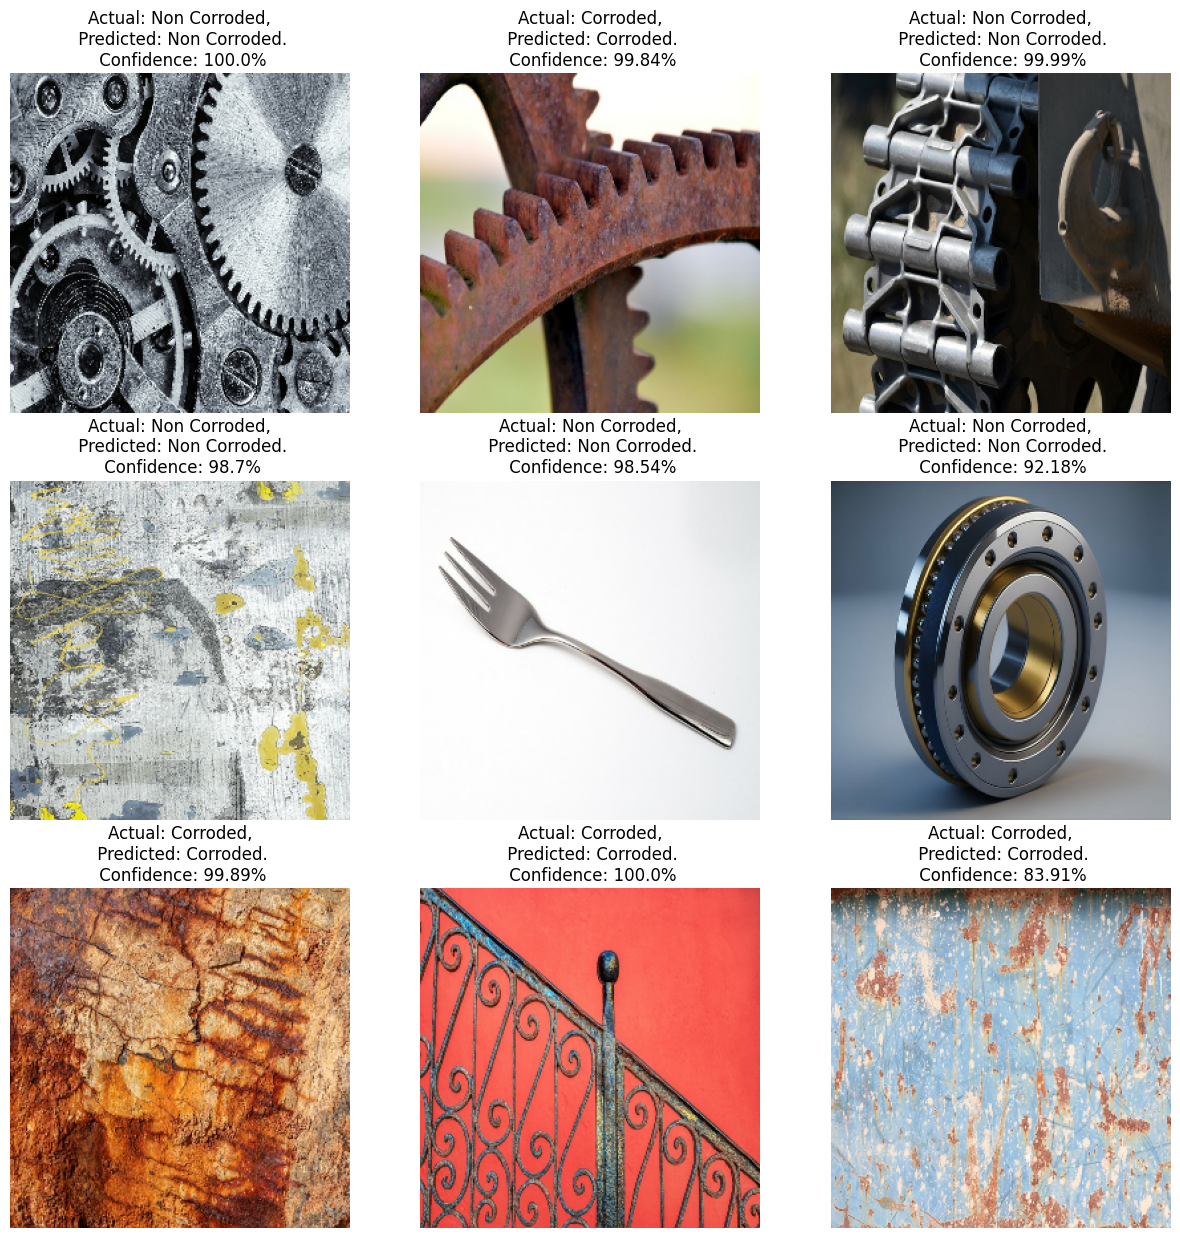

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
import os

# Define the path
base_path = r"C:/Users/Mayank Sinha/Downloads/MajorP/Models"
model_path = os.path.join(base_path, "corrdet.h5")

# Save the model
model.save(model_path)
print(f"Model saved at {model_path}")

Model saved at C:/Users/Mayank Sinha/Downloads/MajorP/Models\corrdet.h5


In [4]:
import gradio as gr
import numpy as np
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model("C:/Users/Mayank Sinha/Downloads/MajorP/Models/1")

In [6]:
class_names = ["Non Corroded", "Corroded"]

In [7]:
def predict_image(img):
    try:
        img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
        img_resized = tf.image.resize(img_tensor, (256, 256)) / 255.0  # Resize & Normalize
        img_4d = np.expand_dims(img_resized, axis=0)  # Add batch dimension
        
        prediction = model.predict(img_4d)[0]  # Get prediction
        return {class_names[i]: float(prediction[i]) for i in range(len(class_names))}  # Correct loop

    except Exception as e:
        return {"Error": str(e)}

In [8]:
import gradio as gr
with gr.Blocks() as demo:
    gr.Markdown("# Corrosion Classifier")
    gr.Markdown("Upload an image and get the classification result.")
    
    with gr.Row():
        image = gr.Image(type="numpy", image_mode="RGB", label="Upload Image")
        label = gr.Label(label="Prediction")
    
    btn = gr.Button("Classify")
    btn.click(fn=predict_image, inputs=image, outputs=label)

# Launch app
demo.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\Mayank Sinha\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "C:\Users\Mayank Sinha\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "C:\Users\Mayank Sinha\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\blocks.py", line 1945, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
  File "C:\Users\Mayank Sinha\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\blocks.py", line 1768, in postprocess_data
    prediction_value = block.postprocess(prediction_value)
  File "C:\Users\Mayank Sinha\AppData\Local\Programs\Python\Python38\lib\site-packages\gradio\components\label.py", line 141, in postprocess
    confidences=[
  File "C:\Users\Mayank

Keyboard interruption in main thread... closing server.
